# Analysis of AP systems

**usually: AA weak, AP medium, P dimerization, intra-factor $\alpha=10^5$ ($k^{\text{(a)}}_{on}=10^9$)**

## Preambles

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
#%matplotlib widget
import matplotlib as mpl
import matplotlib.backends.backend_pdf

In [4]:
#mpl.rcParams['figure.figsize'] = [8, 6]
#mpl.rcParams['figure.dpi'] = 300 #72

In [5]:
#
import kainit
import kamix
import kalarm
import kamol
import kaparam
import kareact
import kasig
import kasim
import kasystem
import kaheap
import kamatch
import kaviz
import kasnap
import kagraph
import kaplot

In [6]:
#import commands as cmd

import networkx as nx
import pandas as pd
import numpy as np
from math import ceil

import seaborn as sns

import matplotlib.pyplot as plt
import os
import bz2
import pickle
import sys

In [7]:
snapshot_directory = '/Users/wf7/Desktop/-CombiFluids/SiteSim/PDtest/1/'
csv_directory = snapshot_directory
csv_datafile = csv_directory + 'output.csv'
results_directory = 'Analysis/'

In [8]:
print(f'snapshot_directory = {snapshot_directory}')
print(f'csv_directory = {csv_directory}')
print(f'csv_datafile = {csv_datafile}')
print(f'results_directory = {results_directory}')

snapshot_directory = /Users/wf7/Desktop/-CombiFluids/SiteSim/PDtest/1/
csv_directory = /Users/wf7/Desktop/-CombiFluids/SiteSim/PDtest/1/
csv_datafile = /Users/wf7/Desktop/-CombiFluids/SiteSim/PDtest/1/output.csv
results_directory = Analysis/


## Quick simulation progress check


In [9]:
data = pd.read_csv(csv_datafile, comment='#')
data.columns

Index(['time', ' "AP"', ' "AAP"', ' A.l-A.r', ' A.p-P.a1', ' A.p-P.a2',
       ' A.p-P.a3', ' sz-rank 1', ' sz-rank 2', ' sz-rank 3', ' sz-rank 4',
       ' sz-rank 5'],
      dtype='object')

In [10]:
data.fillna(0, inplace=True)

/Users/wf7/Walter/PycharmProjects/Kappa/KappaUtilities/kaplot.py:72: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  arts, = self.ax.plot(df[x], df[y], 'o-', **self.parameters)
/Users/wf7/Walter/PycharmProjects/Kappa/KappaUtilities/kaplot.py:72: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  arts, = self.ax.plot(df[x], df[y], 'o-', **self.parameters)


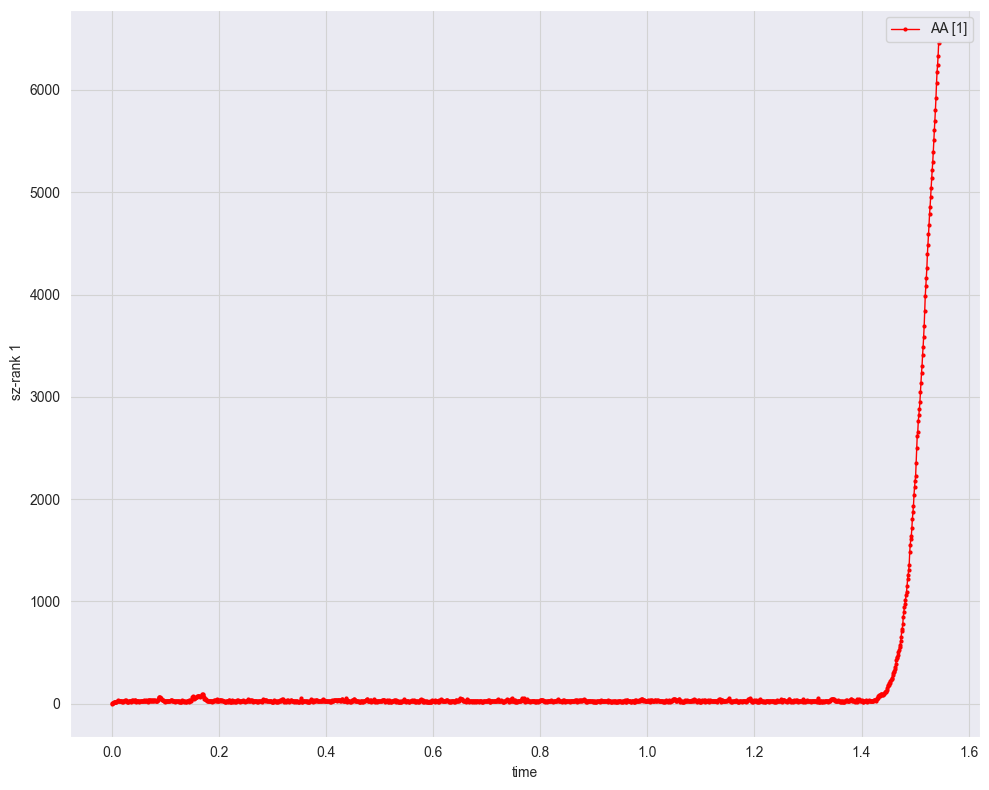

In [11]:
if 'pX' in locals(): plt.close(pX.fig)
pX = kaplot.XY_plot(params={'linestyle': '-', 'linewidth': 1, 'markersize': 2})
pX.ax.set_xscale('linear')
pX.ax.set_yscale('linear')
pX.add(data, x='time', y=' sz-rank 1', params={'label': 'AA', 'color': 'r'})
pX.ax.legend();

## Acquire basic dataframes from snapshots

In [17]:
def patterns(snapshot, pats):

    # get a site graph matcher
    SGM = kamatch.SiteGraphMatcher()

    # turn the patterns into internal representations
    ip = [kamol.KappaComplex(p, canon=False) for p in pats]

    # read the snapshot
    print(f' scanning {snapshot}', end='\r')
    snap = kasnap.SnapShot(snapshot)
    print(f'analyzing {snapshot}', end='\r')

    all_lv = list(snap.local_views.keys())
    columns = ['complex', 'size', 'count', 'composition'] + all_lv + pats
    df = pd.DataFrame(columns=columns)
    data = []

    # sort complexes with decreasing size
    snap.complexes.sort(key=lambda m: m.size, reverse=True)

    idx = 1
    for c in snap.complexes:
        # distinguishable embeddings in c modulo automorphisms
        pattern_count = []
        local = []
        for p in ip:
            pattern_count.append(SGM.number_of_all_embeddings(c, p) / len(SGM.automorphisms(p)))
        for lv in all_lv:
            if lv in c.local_views:
                local.append(len(c.local_views[lv]))
            else:
                local.append(0)
        data.append([idx, c.size, c.count, c.composition] + local + pattern_count)
        idx += 1

    # fill the dataframe

    df = df.append(pd.DataFrame(data, columns=columns))
    print(f'done {" ":30}')
    return df

In [18]:
pats = ['A(p[.])', 
        'A(l[.])', 
        'A(r[.])', 
        'A(l[.] r[.])', 
        'P(d[.])', 'P(a1[.])', 
        'P(a2[.])',
        'P(a3[.])', 
        'A(r[1]), A(l[1])', 
        'A(p[1]), P(a1[1])', 
        'A(p[1]), P(a2[1])', 
        'A(p[1]), P(a3[1])', 
        'P(d[1]), P(d[1])']

In [19]:
df = patterns(snapshot_directory + 'snap154.ka', pats)

done                               Fluids/SiteSim/PDtest/1/snap154.ka


/var/folders/z5/55fphr6j2ls5sgv30v1ynhg80000gq/T/ipykernel_85733/3084602446.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data, columns=columns))


In [20]:
df.set_index('complex', inplace=True)

In [21]:
pd.set_option('display.max_columns', None)

In [22]:
df

,size,count,composition,A(l[.] p[.] r[.]),P(a1[.] a2[.] a3[.] d[.]),A(l[.] p[P.a3] r[.]),P(a1[.] a2[.] a3[A.p] d[.]),A(l[A.r] p[P.a1] r[.]),A(l[.] p[.] r[A.l]),P(a1[A.p] a2[.] a3[.] d[.]),A(l[.] p[P.a1] r[.]),A(l[A.r] p[.] r[.]),A(l[.] p[P.a2] r[.]),P(a1[.] a2[A.p] a3[.] d[.]),A(l[.] p[P.a1] r[A.l]),P(a1[A.p] a2[.] a3[A.p] d[.]),P(a1[.] a2[.] a3[.] d[P.d]),A(l[A.r] p[P.a3] r[.]),P(a1[.] a2[A.p] a3[A.p] d[.]),A(l[A.r] p[.] r[A.l]),P(a1[.] a2[.] a3[A.p] d[P.d]),A(l[.] p[P.a3] r[A.l]),P(a1[A.p] a2[A.p] a3[.] d[.]),A(l[A.r] p[P.a2] r[.]),A(l[.] p[P.a2] r[A.l]),P(a1[.] a2[A.p] a3[A.p] d[P.d]),P(a1[A.p] a2[.] a3[A.p] d[P.d]),A(l[A.r] p[P.a1] r[A.l]),P(a1[A.p] a2[.] a3[.] d[P.d]),P(a1[.] a2[A.p] a3[.] d[P.d]),P(a1[A.p] a2[A.p] a3[A.p] d[.]),A(l[A.r] p[P.a2] r[A.l]),P(a1[A.p] a2[A.p] a3[.] d[P.d]),A(l[A.r] p[P.a3] r[A.l]),P(a1[A.p] a2[A.p] a3[A.p] d[P.d]),A(p[.]),A(l[.]),A(r[.]),A(l[.] r[.]),P(d[.]),P(a1[.]),P(a2[.]),P(a3[.]),"A(r[1]), A(l[1])","A(p[1]), P(a1[1])","A(p[1]), P(a2[1])","A(p[1]), P(a3[1])","P(d[1]), P(d[1])"
complex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,6063,1,"{'P': 1844, 'A': 4219}",0,0,3,1,79,0,8,5,2,2,1,77,6,30,66,5,5,72,65,9,70,75,221,246,1269,79,84,12,1255,253,1246,817,7.0,227.0,227.0,10.0,42.0,414.0,442.0,464.0,3992.0,1430.0,1402.0,1380.0,901.0
2,18,1,"{'P': 8, 'A': 10}",0,0,1,0,1,0,0,1,0,0,0,0,1,2,2,1,0,1,1,0,1,3,1,0,0,0,1,0,0,1,0,0,0.0,6.0,6.0,2.0,2.0,6.0,4.0,4.0,4.0,2.0,4.0,4.0,3.0
3,13,1,"{'P': 5, 'A': 8}",0,0,2,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,2,0,1,1,0,0,0,1.0,4.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,3.0,2.0,2.0,2.0
4,13,1,"{'P': 5, 'A': 8}",0,0,0,0,1,0,0,1,0,2,0,1,0,1,1,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0.0,5.0,5.0,3.0,1.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0
5,12,1,"{'P': 4, 'A': 8}",0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,2,0,0,2,0,1,0,0,3,0,0,1.0,3.0,3.0,1.0,0.0,1.0,0.0,4.0,5.0,3.0,4.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2,736,"{'A': 1, 'P': 1}",0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
356,2,781,"{'A': 1, 'P': 1}",0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
357,2,608,{'P': 2},0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
n = 0
for i in range(1, len(df) + 1):
    n += df.loc[i,'patterns']['A(r[1]), A(l[1])'] * df.loc[i,'count']
print(f'[{i}] {n}')